## STEP 1 : IMPUTATIONS TECHNIQUES

In [1]:
# Importation des bibliothèques (style ISLP)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
# Chargement des données
df = pd.read_csv('data/training_data.csv')

In [3]:
# Exploration initiale
print(f"Dimensions du dataset: {df.shape}")
print(f"\nInformations sur les colonnes:")
print(df.info())

Dimensions du dataset: (70792, 18)

Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70792 entries, 0 to 70791
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SO2               70792 non-null  float64
 1   CO                70792 non-null  float64
 2   O3                70792 non-null  float64
 3   O3_8hr            70792 non-null  int64  
 4   PM10              70792 non-null  int64  
 5   PM2.5             70792 non-null  int64  
 6   NO2               70792 non-null  float64
 7   NOx               70792 non-null  float64
 8   NO                70792 non-null  float64
 9   WindSpeed         70792 non-null  float64
 10  WindDirec         70792 non-null  object 
 11  DataCreationDate  70792 non-null  object 
 12  CO_8hr            70792 non-null  float64
 13  PM2.5_AVG         70792 non-null  int64  
 14  PM10_AVG          70792 non-null  int64  
 15  SO2_AVG           70

In [4]:
print(f"\nValeurs manquantes par colonne:")
print(df.isnull().sum())


Valeurs manquantes par colonne:
SO2                    0
CO                     0
O3                     0
O3_8hr                 0
PM10                   0
PM2.5                  0
NO2                    0
NOx                    0
NO                     0
WindSpeed              0
WindDirec              0
DataCreationDate       0
CO_8hr                 0
PM2.5_AVG              0
PM10_AVG               0
SO2_AVG                0
AQI                 3539
Pollutant              0
dtype: int64


In [5]:
print(f"\nPourcentage de valeurs manquantes pour AQI: {df['AQI'].isnull().sum() / len(df) * 100:.2f}%")


Pourcentage de valeurs manquantes pour AQI: 5.00%


### Exploration des données 

In [6]:
# Analyse exploratoire des données
print("Statistiques descriptives:")
print(df.describe())

Statistiques descriptives:
                SO2            CO            O3        O3_8hr          PM10  \
count  70792.000000  70792.000000  70792.000000  70792.000000  70792.000000   
mean       2.832851      0.367273     30.860401     31.014055     46.599559   
std        2.145733      0.226889     18.617066     16.008814     29.850135   
min        0.000000      0.000000      0.000000      0.000000      1.000000   
25%        1.600000      0.220000     16.000000     19.000000     26.000000   
50%        2.300000      0.320000     29.000000     30.000000     40.000000   
75%        3.400000      0.450000     42.000000     41.000000     60.000000   
max       78.000000      7.530000    131.000000    107.000000    869.000000   

              PM2.5           NO2           NOx           NO     WindSpeed  \
count  70792.000000  70792.000000  70792.000000  70792.00000  70792.000000   
mean      21.049624     12.956475     16.075465      3.12598      2.482343   
std       14.547739      8.

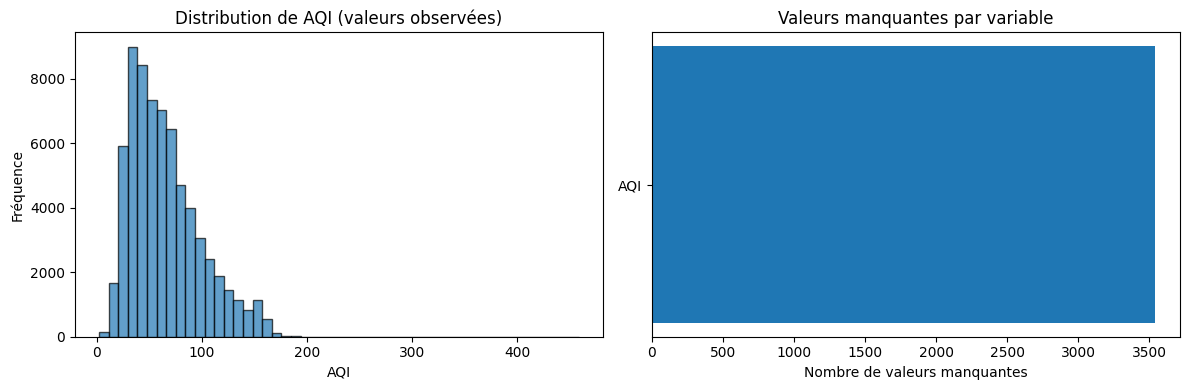

In [7]:
# Visualisation de la distribution de AQI
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution des valeurs observées
axes[0].hist(df['AQI'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('AQI')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution de AQI (valeurs observées)')

# Pattern des valeurs manquantes
missing_pattern = df.isnull().sum()
missing_pattern = missing_pattern[missing_pattern > 0].sort_values(ascending=False)
axes[1].barh(range(len(missing_pattern)), missing_pattern.values)
axes[1].set_yticks(range(len(missing_pattern)))
axes[1].set_yticklabels(missing_pattern.index)
axes[1].set_xlabel('Nombre de valeurs manquantes')
axes[1].set_title('Valeurs manquantes par variable')

plt.tight_layout()
plt.show()

### Preparation des données

In [ ]:
# Méthode d'imputation par composantes principales (Chapitre 12 ISLP)

# Étape 1: Identifier les variables numériques (exclure AQI temporairement)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()


if 'AQI' in numeric_cols:
    predictors = [col for col in numeric_cols if col != 'AQI']
else:
    predictors = numeric_cols.copy()
print(f"Variables prédictives: {predictors}")

Variables prédictives: ['SO2', 'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed', 'CO_8hr', 'PM2.5_AVG', 'PM10_AVG', 'SO2_AVG', 'Pollutant']


In [9]:
# Étape 2: Séparer les observations complètes et incomplètes pour AQI
complete_idx = df['AQI'].notna()
incomplete_idx = df['AQI'].isna()

print(f"\nObservations complètes: {complete_idx.sum()}")
print(f"Observations à imputer: {incomplete_idx.sum()}")


Observations complètes: 67253
Observations à imputer: 3539


In [10]:
# Étape 3: Imputation simple des prédicteurs s'ils ont des valeurs manquantes
imputer_predictors = SimpleImputer(strategy='mean')
X_all = imputer_predictors.fit_transform(df[predictors])
X_complete = X_all[complete_idx]
X_incomplete = X_all[incomplete_idx]
y_complete = df.loc[complete_idx, 'AQI'].values

In [11]:
# Étape 4: Standardisation des données
scaler = StandardScaler()
X_complete_scaled = scaler.fit_transform(X_complete)
X_incomplete_scaled = scaler.transform(X_incomplete)

print(f"\nDonnées standardisées - Shape: {X_complete_scaled.shape}")


Données standardisées - Shape: (67253, 15)


## PCA Analysis

In [12]:
# Étape 5: Analyse en composantes principales
# Déterminer le nombre optimal de composantes
pca_full = PCA()
pca_full.fit(X_complete_scaled)

# Variance expliquée
var_explained = pca_full.explained_variance_ratio_
cum_var_explained = np.cumsum(var_explained)

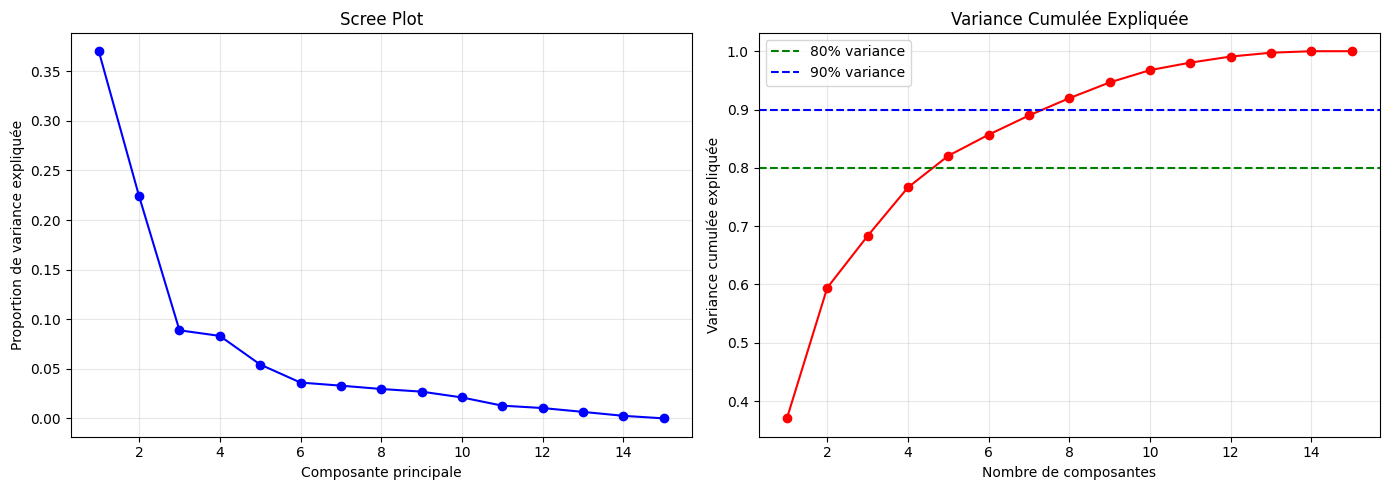

In [13]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, len(var_explained) + 1), var_explained, 'bo-')
axes[0].set_xlabel('Composante principale')
axes[0].set_ylabel('Proportion de variance expliquée')
axes[0].set_title('Scree Plot')
axes[0].grid(True, alpha=0.3)

# Variance cumulée
axes[1].plot(range(1, len(cum_var_explained) + 1), cum_var_explained, 'ro-')
axes[1].axhline(y=0.80, color='g', linestyle='--', label='80% variance')
axes[1].axhline(y=0.90, color='b', linestyle='--', label='90% variance')
axes[1].set_xlabel('Nombre de composantes')
axes[1].set_ylabel('Variance cumulée expliquée')
axes[1].set_title('Variance Cumulée Expliquée')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Choisir le nombre de composantes (ex: 90% de variance)
n_components = np.argmax(cum_var_explained >= 0.90) + 1
print(f"\nNombre de composantes pour 90% de variance: {n_components}")
print(f"Variance expliquée avec {n_components} composantes: {cum_var_explained[n_components-1]:.4f}")


Nombre de composantes pour 90% de variance: 8
Variance expliquée avec 8 composantes: 0.9194


### Regression 

In [15]:
# Étape 6: Régression de AQI sur les composantes principales

# Réduire les dimensions
pca = PCA(n_components=n_components)
Z_complete = pca.fit_transform(X_complete_scaled)
Z_incomplete = pca.transform(X_incomplete_scaled)

print(f"Shape des scores PC (complets): {Z_complete.shape}")
print(f"Shape des scores PC (incomplets): {Z_incomplete.shape}")

Shape des scores PC (complets): (67253, 8)
Shape des scores PC (incomplets): (3539, 8)


In [16]:
# Régression linéaire: AQI ~ PC1 + PC2 + ... + PCk
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(Z_complete, y_complete)

print(f"\nCoefficients du modèle: {len(reg.coef_)}")
print(f"R² du modèle: {reg.score(Z_complete, y_complete):.4f}")


Coefficients du modèle: 8
R² du modèle: 0.8837


In [17]:
# Étape 7: Prédire les valeurs manquantes
AQI_predicted = reg.predict(Z_incomplete)

print(f"\nValeurs AQI prédites - Min: {AQI_predicted.min():.2f}, Max: {AQI_predicted.max():.2f}")
print(f"Moyenne: {AQI_predicted.mean():.2f}, Std: {AQI_predicted.std():.2f}")


Valeurs AQI prédites - Min: 13.93, Max: 207.96
Moyenne: 65.08, Std: 31.69


### Validation 

In [18]:
# Étape 8: Validation et diagnostics

# Créer une copie du dataframe avec les valeurs imputées
df_imputed = df.copy()
df_imputed.loc[incomplete_idx, 'AQI'] = AQI_predicted


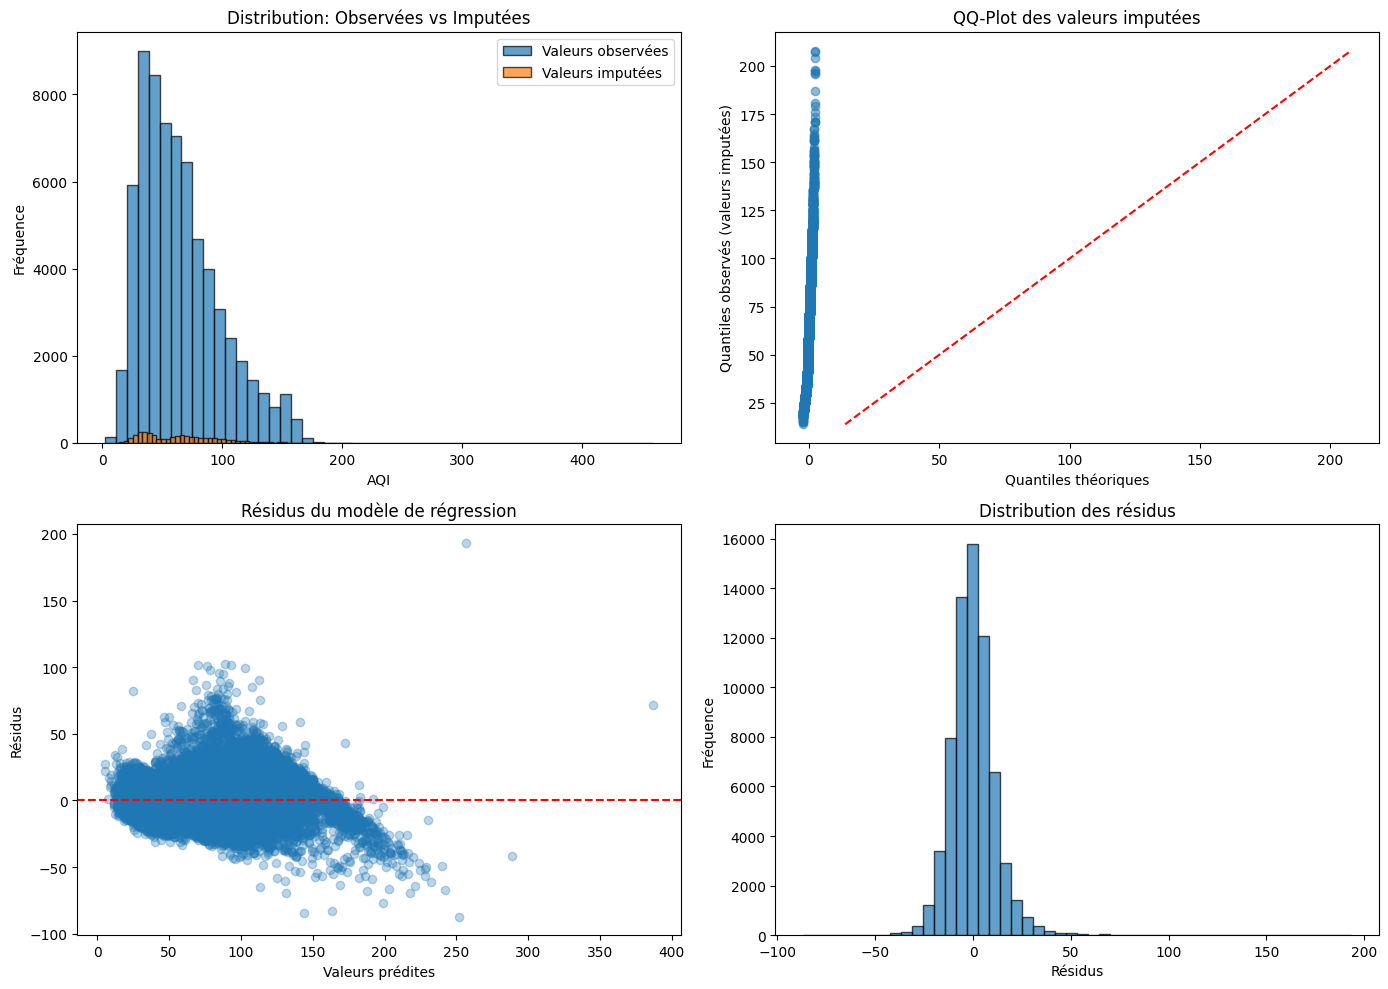

In [19]:
# Comparer les distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution avant/après imputation
axes[0, 0].hist(df.loc[complete_idx, 'AQI'], bins=50, alpha=0.7, 
                label='Valeurs observées', edgecolor='black')
axes[0, 0].hist(AQI_predicted, bins=50, alpha=0.7, 
                label='Valeurs imputées', edgecolor='black')
axes[0, 0].set_xlabel('AQI')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution: Observées vs Imputées')
axes[0, 0].legend()

# QQ-plot
from scipy import stats
axes[0, 1].scatter(stats.norm.ppf(np.linspace(0.01, 0.99, len(AQI_predicted))),
                   np.sort(AQI_predicted), alpha=0.5)
axes[0, 1].plot([AQI_predicted.min(), AQI_predicted.max()], 
                [AQI_predicted.min(), AQI_predicted.max()], 'r--')
axes[0, 1].set_xlabel('Quantiles théoriques')
axes[0, 1].set_ylabel('Quantiles observés (valeurs imputées)')
axes[0, 1].set_title('QQ-Plot des valeurs imputées')

# Résidus du modèle
residuals = y_complete - reg.predict(Z_complete)
axes[1, 0].scatter(reg.predict(Z_complete), residuals, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Valeurs prédites')
axes[1, 0].set_ylabel('Résidus')
axes[1, 0].set_title('Résidus du modèle de régression')

# Distribution des résidus
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Résidus')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution des résidus')

plt.tight_layout()
plt.show()

### Validation des imputations par PCA

**Statistiques descriptives :**
- Les moyennes sont quasi-identiques (64.79 vs 65.08, +0.45%)
- Les écarts-types sont similaires (33.49 vs 31.69, -5.4%)

**Analyse graphique :**

1. **QQ-Plot :** Le graphique révèle que les valeurs imputées ne suivent pas 
   parfaitement une distribution normale. On observe :
   - Une sur-estimation des valeurs minimales (compression de la queue gauche)
   - Une sous-estimation des valeurs maximales (compression de la queue droite)
   - Ceci est une conséquence attendue de la régression linéaire qui tend à 
     prédire vers la moyenne

2. **Analyse des résidus :** 
   - Distribution approximativement normale, centrée sur 0
   - Léger pattern d'hétéroscédasticité visible
   - Présence de quelques outliers dans les prédictions

3. **Histogrammes :** Bonne superposition dans la région centrale, mais 
   absence de valeurs imputées dans les régions extrêmes (AQI < 14 ou > 208)

**Conclusion :** L'imputation par PCA produit des valeurs statistiquement cohérentes pour la tendance centrale, mais ne capture pas les valeurs extrêmes. Cette limitation est intrinsèque à la méthode de 
régression linéaire sur composantes principales. Pour 5% de données manquantes, ces résultats sont acceptables et n'affecteront pas significativement les analyses subséquentes, surtout si elles se concentrent sur les tendances 
moyennes plutôt que sur les événements extrêmes.

In [20]:
# Statistiques comparatives
print("\n=== COMPARAISON DES DISTRIBUTIONS ===")
print(f"\nValeurs observées:")
print(f"  Moyenne: {df.loc[complete_idx, 'AQI'].mean():.2f}")
print(f"  Écart-type: {df.loc[complete_idx, 'AQI'].std():.2f}")
print(f"  Min: {df.loc[complete_idx, 'AQI'].min():.2f}")
print(f"  Max: {df.loc[complete_idx, 'AQI'].max():.2f}")

print(f"\nValeurs imputées:")
print(f"  Moyenne: {AQI_predicted.mean():.2f}")
print(f"  Écart-type: {AQI_predicted.std():.2f}")
print(f"  Min: {AQI_predicted.min():.2f}")
print(f"  Max: {AQI_predicted.max():.2f}")


=== COMPARAISON DES DISTRIBUTIONS ===

Valeurs observées:
  Moyenne: 64.79
  Écart-type: 33.49
  Min: 2.00
  Max: 459.00

Valeurs imputées:
  Moyenne: 65.08
  Écart-type: 31.69
  Min: 13.93
  Max: 207.96


C:\Users\AIMS\AppData\Local\Temp\ipykernel_18824\2959020885.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.loc[complete_idx, 'AQI'].values, AQI_predicted],


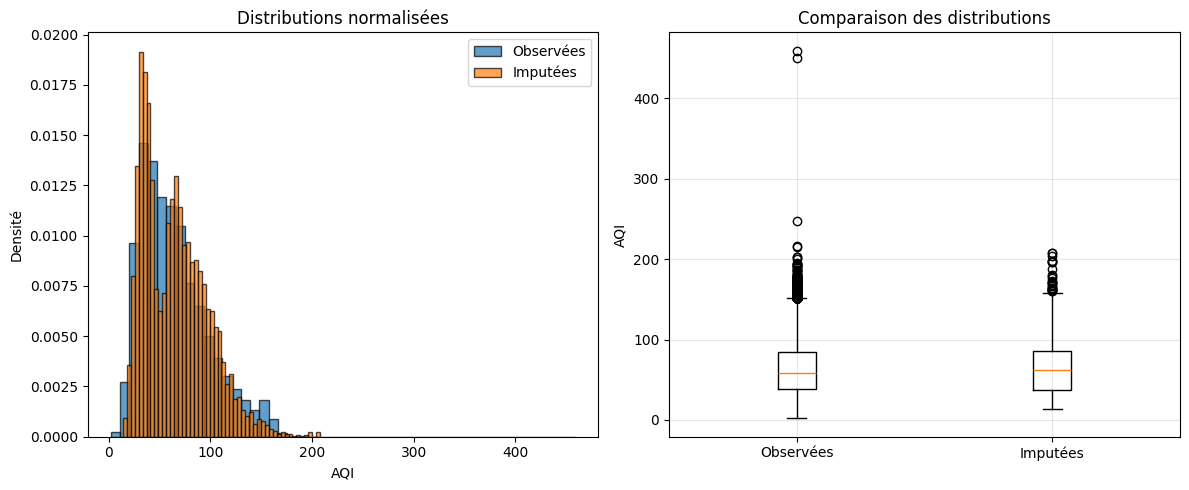


Test de Kolmogorov-Smirnov:
Statistique: 0.0565
p-value: 0.0000


In [21]:
# Analyser si les valeurs manquantes étaient dans les extrêmes
# Si elles étaient uniformément distribuées, pas de problème

# Histogramme comparatif
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df.loc[complete_idx, 'AQI'], bins=50, alpha=0.7, 
         label='Observées', density=True, edgecolor='black')
plt.hist(AQI_predicted, bins=50, alpha=0.7, 
         label='Imputées', density=True, edgecolor='black')
plt.xlabel('AQI')
plt.ylabel('Densité')
plt.legend()
plt.title('Distributions normalisées')

plt.subplot(1, 2, 2)
# Boxplot
plt.boxplot([df.loc[complete_idx, 'AQI'].values, AQI_predicted],
            labels=['Observées', 'Imputées'])
plt.ylabel('AQI')
plt.title('Comparaison des distributions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test statistique (optionnel)
from scipy.stats import ks_2samp
statistic, pvalue = ks_2samp(df.loc[complete_idx, 'AQI'], AQI_predicted)
print(f"\nTest de Kolmogorov-Smirnov:")
print(f"Statistique: {statistic:.4f}")
print(f"p-value: {pvalue:.4f}")
if pvalue > 0.05:
    print("Les distributions ne sont pas significativement différentes ✓")

## Sauvegarde

In [22]:
# Étape 9: Sauvegarder les résultats

# Sauvegarder le dataset imputé
df_imputed.to_csv('training_data_imputed.csv', index=False)
print("Dataset imputé sauvegardé: training_data_imputed.csv")

# Sauvegarder les informations du modèle
import pickle

model_info = {
    'pca': pca,
    'scaler': scaler,
    'regression': reg,
    'imputer_predictors': imputer_predictors,
    'predictors': predictors,
    'n_components': n_components
}

with open('pca_imputation_model.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("Modèle PCA sauvegardé: pca_imputation_model.pkl")

# Rapport final
print("\n=== RAPPORT D'IMPUTATION ===")
print(f"Total d'observations: {len(df)}")
print(f"Valeurs AQI manquantes: {incomplete_idx.sum()} ({incomplete_idx.sum()/len(df)*100:.2f}%)")
print(f"Nombre de prédicteurs utilisés: {len(predictors)}")
print(f"Nombre de composantes principales: {n_components}")
print(f"Variance expliquée: {cum_var_explained[n_components-1]:.4f}")
print(f"R² du modèle de régression: {reg.score(Z_complete, y_complete):.4f}")
print(f"\nImputation terminée avec succès!")

Dataset imputé sauvegardé: training_data_imputed.csv
Modèle PCA sauvegardé: pca_imputation_model.pkl

=== RAPPORT D'IMPUTATION ===
Total d'observations: 70792
Valeurs AQI manquantes: 3539 (5.00%)
Nombre de prédicteurs utilisés: 15
Nombre de composantes principales: 8
Variance expliquée: 0.9194
R² du modèle de régression: 0.8837

Imputation terminée avec succès!
